Для воспроизводимости кода установим определенную версию tensorflow и keras

In [1]:
#!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 49.3 MB/s 
     |████████████████████████████████| 448 kB 55.7 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [2]:
#!pip install keras==2.3.1

     |████████████████████████████████| 377 kB 6.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

2022-07-10 12:37:28.917506: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-10 12:37:28.920069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 12:37:28.920077: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.9.1
We are using Keras 2.9.0


In [4]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

2022-07-10 12:37:57.884195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 12:37:57.884912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-10 12:37:57.884925: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-10 12:37:57.884937: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ls01): /proc/driver/nvidia/version does not exist


''

In [5]:
#GPU count and name
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


In [6]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# MNIST

In [7]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [8]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


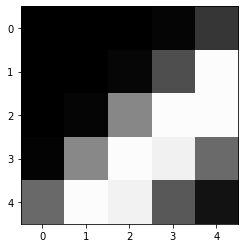

Пример картинки:


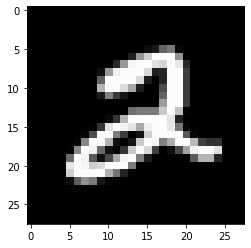

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [9]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

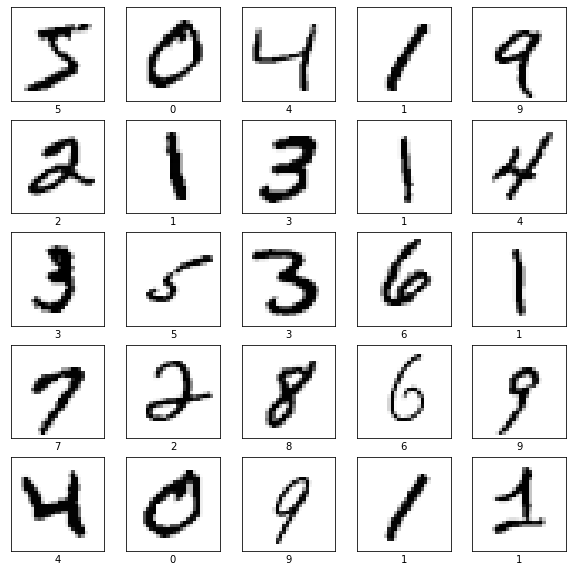

In [10]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [11]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [13]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(float)
# x_val_float = x_val_flat.astype(float)

In [14]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [ ]:
clear_session()

In [23]:
x_train_float.shape[1]

784

In [15]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [18]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3078 - accuracy: 0.9072 - val_loss: 0.1572 - val_accuracy: 0.9488
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1378 - accuracy: 0.9578 - val_loss: 0.1022 - val_accuracy: 0.9682
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1036 - accuracy: 0.9678 - val_loss: 0.1059 - val_accuracy: 0.9665
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0859 - accuracy: 0.9728 - val_loss: 0.0913 - val_accuracy: 0.9722
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0705 - accuracy: 0.9777 - val_loss: 0.0947 - val_accuracy: 0.9703
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0633 - accuracy: 0.9796 - val_loss: 0.1056 - val_accuracy: 0.9675
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0545 - accuracy: 0.9822 - val_loss: 0.0942 - val_accuracy: 0.9711
Epoch 

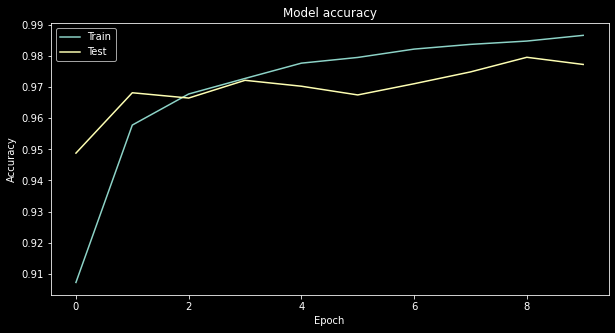

In [19]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

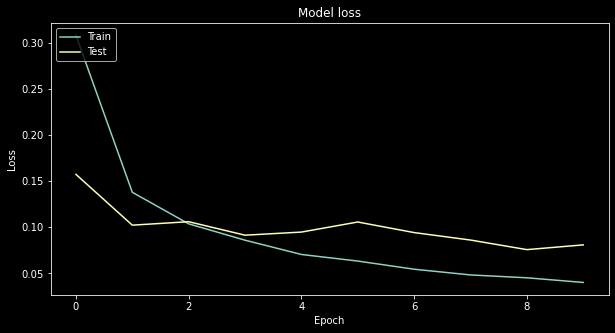

In [20]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.predict(x_val_float)

313/313 [==============================] - 0s 433us/step


array([[1.5048586e-08, 1.1410210e-08, 2.5867794e-06, ..., 9.9999052e-01,
        4.6172917e-07, 3.9030942e-06],
       [5.7689444e-12, 3.5680390e-09, 9.9999279e-01, ..., 2.1455465e-14,
        1.7546657e-09, 2.8539880e-16],
       [1.1504515e-08, 9.9973381e-01, 3.4307199e-05, ..., 1.9155689e-04,
        3.5493629e-06, 1.2699077e-07],
       ...,
       [3.0259714e-13, 4.2488695e-12, 5.8824972e-13, ..., 1.3330166e-05,
        2.4090527e-09, 1.7341889e-06],
       [8.2786399e-12, 2.1226732e-13, 2.3240030e-12, ..., 1.5198081e-11,
        7.3231161e-07, 2.6467264e-14],
       [2.7710192e-10, 3.8412277e-20, 5.6271251e-14, ..., 2.2604954e-19,
        1.6120960e-11, 7.3545304e-13]], dtype=float32)

In [24]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 0s 441us/step


array([7, 2, 1, ..., 4, 5, 6])

In [26]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 444us/step
Test Accuracy:  0.9773
